# Final and complete model

For this model the features extract from the complete description and from the main images of the apartments were used.

### Loading data

In [1]:
import pandas as pd

data = pd.read_csv("C:/Users/cego/OneDrive/Área de Trabalho/Projetos Pessoais/Projeto, apartment prices v2/4_img_feature_extraction/data.csv",
                   sep="|")
data.dropna(subset=["lat", "long"], inplace=True)
data.head()

,id,price,condo_fee,iptu,address,floorSize,numberOfRooms,numberOfBathroomsTotal,numberOfParkingSpaces,floorLevel,...,feature_maps_503,feature_maps_504,feature_maps_505,feature_maps_506,feature_maps_507,feature_maps_508,feature_maps_509,feature_maps_510,feature_maps_511,feature_maps_512
0,62750619205425081544300816117885861273,949900.0,790.0,1900.0,"Rua C238, 100 - Jardim América, Goiânia - GO",130.0,3.0,4.0,2.0,24.0,...,0.127765,3.524587,1.041046,0.016919,0.452591,3.309776,0.982112,0.333408,0.894974,0.448568
1,302678336848826931249389939487192177877,760000.0,NaN,NaN,"Rua T 30, S/N - Setor Bueno, Goiânia - GO",90.0,2.5,2.5,1.5,NaN,...,0.515701,3.463290,0.394959,0.283912,0.211381,0.619300,1.635983,0.501667,0.608028,0.017285
2,130359292211767838527233708900928593543,350000.0,270.0,250.0,"Avenida Marialva, 435 - Vila Rosa, Goiânia - GO",57.0,2.0,1.0,1.0,19.0,...,0.229476,2.309388,0.158572,0.197296,0.073967,0.820991,1.299795,0.337664,0.174766,0.416028
4,200978065182550317495009592604134775241,624700.0,500.0,900.0,"Avenida Dona Maria Cardoso, 735 - Parque Amazô...",72.0,2.0,1.0,1.0,8.0,...,0.203433,1.041208,0.361618,0.499424,0.165279,0.054856,2.148610,0.781782,0.042805,0.157398
5,9796372657926373412148234085533873844,374813.0,NaN,NaN,"Rua Dona Isoleta, 3 - Vila Rosa, Goiânia - GO",61.0,2.0,2.0,1.0,7.0,...,0.000000,0.899192,0.001990,0.930970,0.025143,0.425353,1.415770,1.017306,0.223564,0.723442


### Distance to shopping centers

In [2]:
from haversine import haversine

shoppings = {"Passeio_das_Aguas": (-16.62935338717902, -49.27864911348494),
            "Flamboyant": (-16.709983713886288, -49.237018433761605),
            "Portal_Sul": (-16.770457543653993, -49.35181898957849),
            "Goiânia": (-16.70811433888118, -49.27281973376176),
            "Cerrado": (-16.665992404732286, -49.308465857660444),
            "Portal": (-16.654047808420035, -49.32928694540062),
            "Plaza_Doro": (-16.70722528961973, -49.32804553190786),
            "Cidade_Jardim": (-16.682721816436608, -49.31411186259885),
            "Perimetral_Open_Mall": (-16.642368044349382, -49.307910909152895),
            "Araguaia": (-16.658321034298336, -49.25941657000837),
            "Bouganville": (-16.694169294923878, -49.265424718418366),
            "Buriti": (-16.74178147681141, -49.27701120492441),
            "Lozandes": (-16.692997718702827, -49.22246682530371),
            "Orion_Complex": (-16.69664826311222, -49.270025781651654),
            "Republica": (-16.67823083437392, -49.26693911841769),
            "Anhanguera": (-16.673622640794598, -49.2555401644532),
            "Gallo": (-16.661639216531704, -49.25507395766126),
            "Estacao_Goiania": (-16.66110701599241, -49.261788203072975),
            "Buena_Vista": (-16.710339841635147, -49.26776864725288)}

for key in shoppings.keys():
    data[f"dist_{key}"] = data.apply(lambda row: haversine((row.lat, row.long),
                                                          shoppings[key]), axis=1)

### Preparing training and testing data

In [3]:
import numpy as np

X = data.drop(columns=["id", "price", "address"])
y = np.log10(data["price"].values)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, data_train, data_test, = train_test_split(X, y, data,
                                                                        test_size=.2,
                                                                        random_state=669)

### Clustering over the latitude and longitude

In [5]:
from sklearn.cluster import KMeans

inertia_values = {"k": [],
                  "inertia": []}
for k in range(2, 30):
    for _ in range(15):
        kmeans = KMeans(n_clusters=k, max_iter=10**3, n_init="auto")
        _ = kmeans.fit_predict(X_train[["lat", "long"]])
        inertia_values["k"].append(k)
        inertia_values["inertia"].append(kmeans.inertia_)

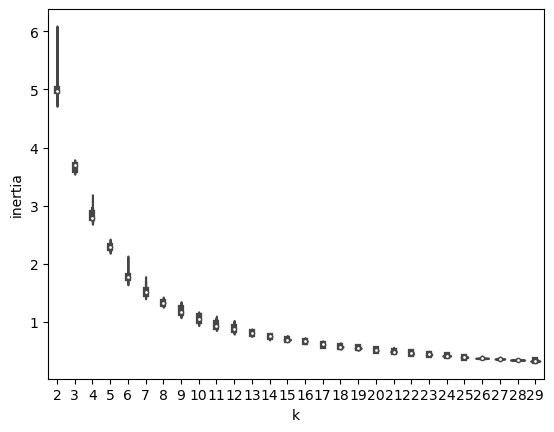

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(pd.DataFrame(inertia_values), x="k", y="inertia")
plt.show()

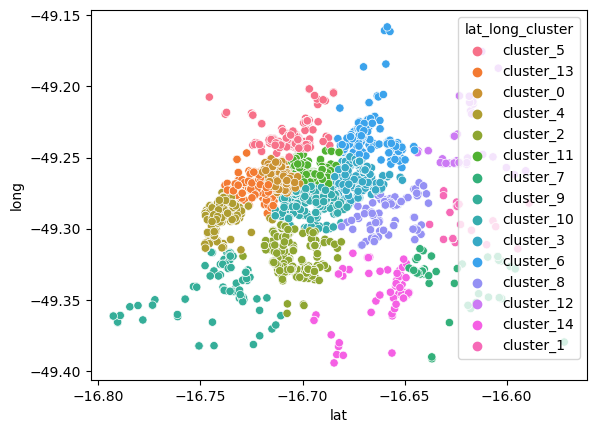

In [7]:
kmeans = KMeans(n_clusters=15, max_iter=10**3, n_init="auto")

X_train["lat_long_cluster"] = kmeans.fit_predict(X_train[["lat", "long"]])
X_train["lat_long_cluster"] = X_train["lat_long_cluster"].apply(lambda x: f"cluster_{str(x)}")

X_test["lat_long_cluster"] = kmeans.predict(X_test[["lat", "long"]])
X_test["lat_long_cluster"] = X_test["lat_long_cluster"].apply(lambda x: f"cluster_{str(x)}")

data_train["lat_long_cluster"] = kmeans.predict(data_train[["lat", "long"]])
data_train["lat_long_cluster"] = data_train["lat_long_cluster"].apply(lambda x: f"cluster_{str(x)}")

data_test["lat_long_cluster"] = kmeans.predict(data_test[["lat", "long"]])
data_test["lat_long_cluster"] = data_test["lat_long_cluster"].apply(lambda x: f"cluster_{str(x)}")

sns.scatterplot(X_train, x="lat", y="long", hue="lat_long_cluster")
plt.show()

In [8]:
X_train.drop(columns=["lat", "long"], inplace=True)
X_test.drop(columns=["lat", "long"], inplace=True)

In [9]:
X_train.columns

Index(['condo_fee', 'iptu', 'floorSize', 'numberOfRooms',
       'numberOfBathroomsTotal', 'numberOfParkingSpaces', 'floorLevel',
       'Cat_pool', 'Cat_elevator', 'Cat_barbecueGrill',
       ...
       'dist_Bouganville', 'dist_Buriti', 'dist_Lozandes',
       'dist_Orion_Complex', 'dist_Republica', 'dist_Anhanguera', 'dist_Gallo',
       'dist_Estacao_Goiania', 'dist_Buena_Vista', 'lat_long_cluster'],
      dtype='object', length=608)

### Preparing regression model and performing hyperparameter tuning

In [10]:
import nltk
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import TruncatedSVD
from StatisticsFromFeatures import StatisticsFromFeatures
from StatisticsFromTarget import StatisticsFromTarget
from sklearn.ensemble import HistGradientBoostingRegressor

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

img_cols = [col for col in X.columns if "feature_maps_" in col]

dist_cols = [col for col in X.columns if "dist_" in col]

cat_cols = [col for col in data.columns if "Cat_" in col]

num_cols = ['floorLevel','condo_fee', 'iptu', 'floorSize',
              'numberOfRooms', 'numberOfBathroomsTotal',
              'numberOfParkingSpaces', 'total_cat', 'description_length']

description_pipe = Pipeline([("tfidf", TfidfVectorizer(stop_words=stopwords, ngram_range=(1,3))),
                             ("dimension_reduction", TruncatedSVD(n_components=15))])

transformer = ColumnTransformer([("img_pipe", TruncatedSVD(n_components=15), img_cols),
                                ("description_pipe", description_pipe, "complete_description"),
                                ("dist", TruncatedSVD(n_components=3), dist_cols),
                                ("cat", TruncatedSVD(n_components=10), cat_cols),
                                ("stats_from_features", StatisticsFromFeatures(["lat_long_cluster"], num_cols), ["lat_long_cluster"] + num_cols),
                                ("stats_from_target", StatisticsFromTarget(["lat_long_cluster"]), ["lat_long_cluster"])],
                                remainder="passthrough")

model = HistGradientBoostingRegressor(max_iter=1000)
model_pipe = Pipeline([("preprocessing", transformer),
                      ("model", model)])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
from sklearn.metrics import make_scorer
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV

param_distributions = {"model__learning_rate": Real(1e-5, 1, prior="log-uniform"),
                      "model__max_leaf_nodes": Integer(3, 150, prior="uniform"),
                      "model__l2_regularization": Real(1e-6, 1, prior="log-uniform"),
                      "model__min_samples_leaf": Integer(5, 600, prior="uniform"),
                      "model__loss": Categorical(["squared_error", "absolute_error"])}

def scoring(y_true, y_pred):
    y_true = 10**y_true
    y_pred = 10**y_pred
    pct_error = np.abs(y_pred - y_true)/y_true
    return np.mean(pct_error <= .2)

bs_model = BayesSearchCV(model_pipe,
                           param_distributions,
                           cv=3,
                           n_iter=100,
                           scoring=make_scorer(scoring),
                           n_jobs=1,
                           random_state=668,
                           verbose=10)

In [12]:
np.int = int
bs_model.fit(X_train, y_train)
y_pred = bs_model.predict(X_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START model__l2_regularization=0.015045555560974122, model__learning_rate=0.10613472205446763, model__loss=squared_error, model__max_leaf_nodes=131, model__min_samples_leaf=349
[CV 1/3; 1/1] END model__l2_regularization=0.015045555560974122, model__learning_rate=0.10613472205446763, model__loss=squared_error, model__max_leaf_nodes=131, model__min_samples_leaf=349;, score=0.712 total time=  10.6s
[CV 2/3; 1/1] START model__l2_regularization=0.015045555560974122, model__learning_rate=0.10613472205446763, model__loss=squared_error, model__max_leaf_nodes=131, model__min_samples_leaf=349
[CV 2/3; 1/1] END model__l2_regularization=0.015045555560974122, model__learning_rate=0.10613472205446763, model__loss=squared_error, model__max_leaf_nodes=131, model__min_samples_leaf=349;, score=0.704 total time=  10.7s
[CV 3/3; 1/1] START model__l2_regularization=0.015045555560974122, model__learning_rate=0.10613472205446763, model_

In [13]:
import dill

with open("final_model/fitted_model.pk", "wb") as file:
    dill.dump(bs_model, file)

with open("final_model/data_train_test.pk", "wb") as file:
    dill.dump({"train": data_train,
              "test": data_test}, file)

### Performance plots

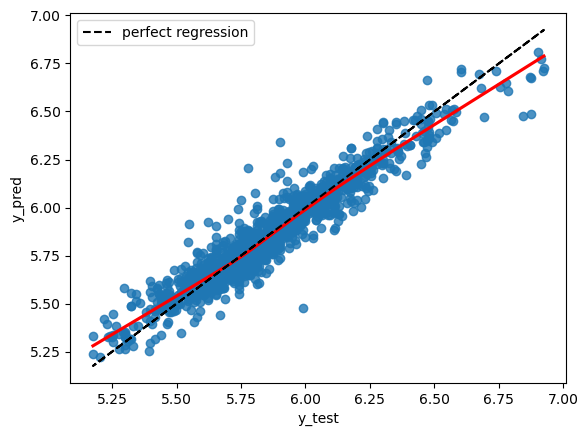

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.regplot(x=y_test, y=y_pred, line_kws=dict(color="r"), lowess=True)
plt.plot(y_test, y_test, color="black", linestyle="--", label="perfect regression")
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.legend()
plt.savefig("final_model/fig1.png", dpi=400)
plt.show()

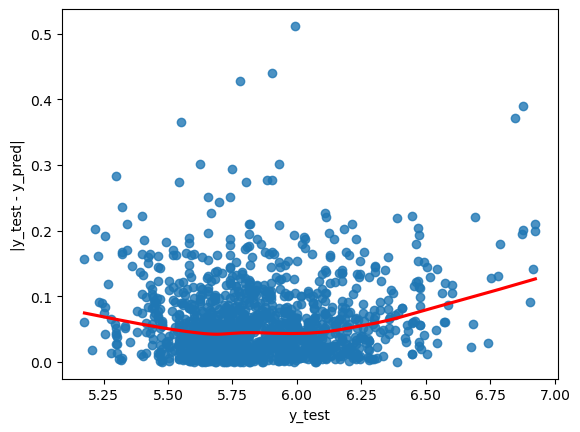

In [15]:
sns.regplot(x=y_test, y=np.abs(y_test - y_pred),
            lowess=True, line_kws=dict(color="r"))
plt.xlabel("y_test")
plt.ylabel("|y_test - y_pred|")
plt.savefig("final_model/fig2.png", dpi=400)
plt.show()

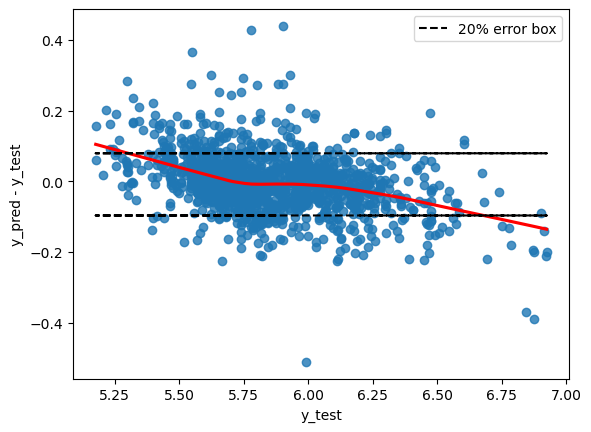

In [16]:
sns.regplot(x=y_test, y=y_pred - y_test,
            lowess=True, line_kws=dict(color="r"))
plt.plot(y_test, [np.log10(1.20)]*len(y_test), color="black",
         linestyle="--",
         label="20% error box")
plt.plot(y_test, [np.log10(0.80)]*len(y_test), color="black",
         linestyle="--")
plt.xlabel("y_test")
plt.ylabel("y_pred - y_test")
plt.legend()
plt.savefig("final_model/fig3.png", dpi=400)
plt.show()

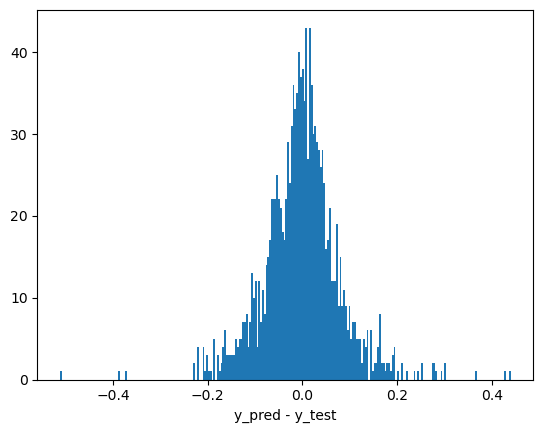

In [17]:
plt.hist(y_pred - y_test, bins=250)
plt.xlabel("y_pred - y_test")
plt.savefig("final_model/fig4.png", dpi=400)
plt.show()

The score below tells the percentage of the test that for which there is a maximum of 20% error. Note that we achieved a significant improvement compared to the base model with stats.

In [18]:
scoring(y_test, y_pred)

0.7784172661870503